# Spanish ULMFiT from scratch (backwards)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import SaveModelCallback

In [2]:
bs=96

In [3]:
data_path = Config.data_path()
lang = 'es'
name = f'{lang}wiki'
path = data_path/name
dest = path/'docs'
lm_fns = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

## Spanish wikipedia model

In [4]:
# data = (TextList.from_folder(dest)
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()
#             .databunch(bs=bs, num_workers=1, backwards=True))

# data.save(f'{lang}_databunch_bwd')

In [5]:
data = load_data(dest, f'{lang}_databunch_bwd', bs=bs, backwards=True)

In [6]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [7]:
learn.lr_find(start_lr=1e-3, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


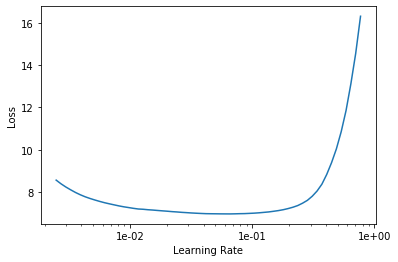

In [8]:
learn.recorder.plot()

In [9]:
lr = 1e-2
# lr *= bs/48  # Scale learning rate by batch size

In [10]:
learn.unfreeze()
# learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.444012,3.411050,0.423217,3:31:34
1,3.573076,3.526484,0.411462,3:31:09
2,3.572197,3.566270,0.407482,3:30:57
3,3.544393,3.556223,0.408801,3:32:01
4,3.571290,3.522106,0.412222,3:36:52
5,3.512694,3.457823,0.418018,3:31:02
6,3.441303,3.388884,0.424103,3:31:20
7,3.370762,3.299700,0.433455,3:30:58
8,3.321628,3.212045,0.442560,3:29:54
9,3.300446,3.176915,0.446884,3:31:57


In [11]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

## Spanish sentiment analysis

### Language model

In [4]:
train_df = pd.read_csv(path/'train.csv')
train_df.loc[pd.isna(train_df.tweet),'tweet']='NA'

val_df = pd.read_csv(path/'validation.csv')
val_df.loc[pd.isna(val_df.tweet),'tweet']='NA'

test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.tweet),'tweet']='NA'
test_df['label'] = 0

gen_df = pd.read_csv(path/'general.csv')
gen_df.loc[pd.isna(gen_df.tweet),'tweet']='NA'

df = pd.read_csv('tweets-es-pe.csv', header=None)
lm_df = pd.DataFrame()
lm_df['tweet'] = df.loc[:,1]
lm_df.loc[pd.isna(lm_df.tweet),'tweet']='NA'
lm_df['label'] = 0
del df


df = pd.concat([lm_df, gen_df, train_df, val_df, test_df], sort=False)

In [5]:
df.describe()

,label
count,310631.000000
mean,0.032679
std,0.264071
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [6]:
data_lm = (TextList.from_df(df, path, cols='tweet')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152},
                                  pretrained_fnames=lm_fns, drop_mult=1.0)

In [7]:
learn_lm.lr_find(start_lr=1e-4, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


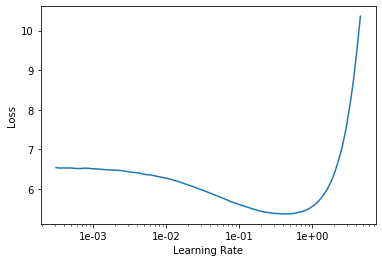

In [8]:
learn_lm.recorder.plot()

In [9]:
lr = 1e-2
lr *= bs/48

In [10]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.081812,4.081781,0.419270,04:23
1,3.805262,3.209117,0.497063,04:31


In [11]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.819729,2.573937,0.600093,04:55
1,2.636906,2.419057,0.620305,04:49
2,2.512447,2.329062,0.631917,04:59
3,2.399664,2.240678,0.644659,04:59
4,2.242429,2.148349,0.657717,04:38
5,2.162553,2.069184,0.670267,04:38
6,2.065350,2.020368,0.677912,04:35
7,1.993171,2.011345,0.679549,04:37


In [12]:
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')

In [13]:
learn_lm.data.show_batch(15)

idx,text
0,"xxup xxbos … enfer sus tratar poder para tiempo tanto esperar que tienen no personas las xxmaj . ” cola “ sólo hacer de trata se no , brother xxmaj : @nicoalessandrap rt xxup xxbos ? orden algún hay nada sé no ? xxunk xxmaj mira se como xxmaj xxbos … verl al él de burlaban se carceleros sus xxmaj . próstata la a cáncer de sufría ya , panóptico"
1,@ensustrece en xxmaj : @ensustrece rt xxup xxbos m xxunk xxmaj / t.co / / : https … l contar sin ( xxunk primera esa en anime el quedo se donde desde completo leí lo me si life re xxmaj espera xxmaj @gjoeldiaz xxbos xxunk / t.co / / : https … contraten que mediocres profesionales tener debemos reflexión tu según entonces xxmaj @clanseros @tuesta xxunk xxbos xxunk / t.co
2,"no interior es felicidad la xxmaj "" xxbos … 2s0 xxup / t.co / / : https maldad la de conocimiento mi y realidad la con encontronazo primer mi fue diadelvladivideo # el que recuerdo : @jortito19 rt xxup xxbos xxunk / t.co / / : https … m san xxmaj de gobernadores los con xxunk minsa xxmaj # del técnico equipo el y broggi xxmaj alfredo xxmaj viceministro el"
3,"mv el es seguro , favs de fav mi hace la q algo tiene breaker xxunk pero uu sé lo dificil es @nelevinee xxbos solos tienen los y huerta la a llevan los , pisos en tengan los no pueblos los en que común muy es que es , claro xxmaj xxunk xxunk xxbos ! todos a días buenos xxmaj xxbos ! ! ! xxunk quiero no , tienda en"
4,"q partidos por ser debería contrato el xxmaj @capital967 @odriozola9 xxbos cjmgfwvhv7 / t.co / / : https ehpwhilx6f / t.co / / : https ► tovar xxmaj carlos xxmaj por , hoy de carlincatura xxmaj # la pierdas te no xxmaj : @larepublica_pe rt xxup xxbos xxunk sus pican le xxmaj . veterinaria la en xxunk xxunk xxmaj xxunk xxbos pasó c mariana xxmaj esa oye , pasa xxup"
5,xxunk xxbos contentos muy veía les se hoy xxbos … h se no extranjero el en que dice también xxmaj . elecciones de adelanto el da se si económica catástrofe una anuncia hernandodesoto # : @jbcperu xxup rt xxup xxbos xxunk / t.co / / : https … xxunk alguna o empleo brindar para cargo un utilizar es nepotismo xxmaj . fernando xxmaj ver a @scheuchmartin xxunk xxbos jajjajajajaja xxup
6,"reflexionar sirvan xfavor invocó xxmaj . bsns \n \n @elgranshow_peru @miluskaeskenazi @elgranshow_peru @leon30013 : xxunk rt xxup xxbos . ptmr 😂 5 xxrep 😨 4 xxrep publicación una a like di le a 15 xxrep a xxbos … exdirect , graña xxmaj hernando xxmaj y josé xxmaj de compromiso el materializado ha se no , fecha la hasta , que admite vela xxmaj rafael xxmaj fiscal xxmaj : @manifiesto_peru"
7,: @waykaperu rt xxup xxbos . democracia haya apenas completamente eliminados ser deben venezuela xxmaj en hay que politiqueros viejos los todos xxmaj xxbos ️ ❤ ! ! xxunk y valoremos xxmaj . familia la a tiempo dedicarle como nada xxmaj xxbos ” xxunk # freud a introducir para @buenafuente y @berto_romero a pongan te filosofía en que xxmaj : xxunk “ ? 6 xxrep xxbos g dlc4ep596 / t.co
8,"en empate el marcó rodríguez xxmaj federico xxmaj ! blanquiazul xxup vamos xxup ¡ ! l o 19 xxrep g ¡ . pt xxup ' ️41 ⏱ : @clubaloficial rt xxup xxbos … po custodiados . portuguesa xxmaj , araure xxmaj de hotel importante en alojados están rusos oficiales 42 1.- \n ! ! ! alerta xxup . hora xxup última xxup : @carlosortegactv rt xxup xxbos … hasta"
9,"ayuda no monto este que consciente ser debe @sportboys hincha el xxmaj : @diegosotomayor7 rt xxup xxbos xxunk / t.co / / : https título el asegurado está casi ya , marquez xxmaj # grande xxmaj : xxunk rt xxup xxbos excelente xxmaj @elvisocc xxbos . humor mal de o triste ponerme , estresarme sin entero día un pasar a llegar es sexual fantasía mi xxmaj : @tipicoarroba rt xxup"


### Classifier

In [27]:
data_clas = (TextList.from_df(pd.concat([train_df, gen_df, val_df]), path, vocab=data_lm.vocab, cols='tweet')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas.save(f'{lang}_textlist_class_bwd')

In [28]:
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [29]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='macro')

In [30]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd')
learn_c.freeze()

In [31]:
learn_c.lr_find(start_lr=1e-4, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


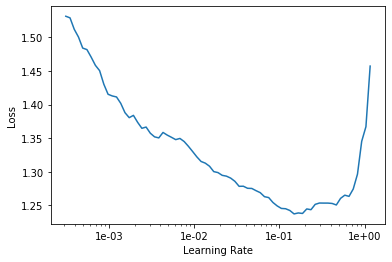

In [32]:
learn_c.recorder.plot()

In [33]:
lr=2e-2
lr *= bs/48

In [34]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.149284,1.124210,0.501718,0.341453,00:01
1,1.076850,1.061082,0.547537,0.410777,00:01


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [35]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.078472,1.041804,0.581901,0.445707,00:01
1,0.990572,0.999608,0.594502,0.460305,00:01


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [36]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.914199,1.018172,0.584192,0.440636,00:02
1,0.790128,1.018686,0.608247,0.489215,00:02


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [37]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.667983,1.064429,0.610538,0.491812,00:03


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
learn_c.save(f'{lang}clas_bwd')

In [21]:
df = pd.read_csv(path/'test_labels.csv')

In [22]:
test_df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])

In [23]:
test_df.head()

,label,tweet
0,0,@LonelySoad mientras que no te pillen la prime...
1,1,@ceemeese ya era hora de volver al csgo y deja...
2,1,@mireiaescribano justo cuando se terminan las ...
3,0,@LuisMartinez22_ pensba q iba a hacer @wxplosi...
4,1,"@Vic_Phantomhive Si lo encuentro, sin compañer..."


In [77]:
data_clas_bwd = (TextList.from_df(pd.concat([train_df, val_df, gen_df]), path, vocab=data_lm.vocab, cols='tweet')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
# .add_test(ItemList.from_df(test_df, path, cols='tweet').split_none().label_from_df(cols='label').databunch())
                 .add_test(test_db)    
#                  .label_from_df(cols='label')
.databunch(bs=bs, num_workers=1, backwards=True))

In [74]:
test_db  = TextList.from_df(test_df, path, cols='tweet')
len(test_db)

1899

In [25]:
# data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [59]:
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_bwd', purge=False)

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7859 items)
x: TextList
xxbos -me caes muy bien 
  xxunk que jugar más partidas al lol con xxmaj xxunk y conmigo 
  xxunk qué tan xxmaj xxunk , deja de ser xxunk 
  xxunk si me muero,xxbos xxunk xxunk que puto mal escribo 
 
  b. me sigo xxunk help 
 
  3 . ha quedado raro el " xxunk " ahí xxup jajajaja,xxbos xxunk jajajaja la tuya y la d mucha gente seguro ! ! xxmaj pero yo no puedo sin mi melena me muero,xxbos xxmaj quiero xxunk a xxunk pero sobretodo por lo rápido que contesta a los xxunk,xxbos xxmaj vale he visto la tia xxunk su regla y me xxunk dado xxunk xxunk
y: CategoryList
3,0,0,1,0
Path: /home/dpalominop/.fastai/data/eswiki;

Valid: LabelList (873 items)
x: TextList
xxbos xxmaj salimos hacia xxmaj madrid porque mañana hay parlamento a primera hora . xxmaj por la tarde debate de empleo y mañana xxunk al repago en sanidad .,xxbos xxup gracias . xxmaj por xxunk en # xxunk xxunk medio mundo . xxmaj amigos d xxunk nos xxunk el 

In [68]:
preds_b,targs_b = learn_c_bwd.get_preds(ds_type=DatasetType.Test, ordered=False)

In [69]:
len(preds_b)

1899

In [75]:
preds_b[:100]

tensor([[9.1445e-01, 3.2458e-02, 4.3998e-02, 9.0972e-03],
        [7.5463e-01, 1.0197e-01, 5.0434e-02, 9.2966e-02],
        [7.7005e-01, 1.0163e-01, 7.7711e-02, 5.0617e-02],
        [4.0142e-03, 9.2273e-01, 9.3515e-03, 6.3906e-02],
        [7.7756e-01, 8.3499e-02, 1.2427e-01, 1.4679e-02],
        [7.3476e-01, 7.2009e-02, 8.7029e-02, 1.0620e-01],
        [2.6451e-03, 9.8691e-01, 7.6913e-03, 2.7558e-03],
        [3.9044e-01, 4.7419e-01, 1.1760e-01, 1.7768e-02],
        [5.6709e-01, 6.9948e-02, 1.2342e-01, 2.3954e-01],
        [6.6408e-01, 1.1378e-01, 1.8649e-01, 3.5645e-02],
        [7.9298e-01, 7.7587e-02, 1.2214e-01, 7.2889e-03],
        [9.4747e-01, 2.3440e-03, 1.9607e-02, 3.0583e-02],
        [7.2789e-01, 1.9735e-01, 5.3064e-02, 2.1703e-02],
        [5.0541e-03, 9.1904e-01, 4.1493e-03, 7.1757e-02],
        [6.9498e-01, 7.6747e-02, 1.9271e-01, 3.5560e-02],
        [1.8525e-01, 6.5818e-01, 1.0718e-01, 4.9384e-02],
        [1.0768e-03, 9.6375e-01, 1.5214e-03, 3.3653e-02],
        [2.880

In [72]:
targs_b[:1000]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [83]:
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.3407), tensor(0.2423))

In [ ]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

In [43]:
len(preds_b)

7859

In [82]:
targs_b = tensor(test_df['label'].to_numpy())

In [84]:
targs_b

tensor([0, 1, 1,  ..., 0, 0, 0])